In [1]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import numpy as np
import scipy as sp
import pandas as pd
import os

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Documents/faculty_hiring/figures/'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

In [3]:
deep_learning_keywords = ["artificial neural network", "ANN", "convolutional neural network", "CNN", "neural",
                          "recurrent neural network", "RNN", "perceptron", "back propagation", "backpropagation", 
                          "deep learning", "deep-learning", "stochastic gradient descent", "SGD", "LSTM", 
                          "long short-term memory", "GAN", "generative adversarial network", "theano", "tensorflow", 
                          "siamese network", "alexnet", "neuron", "neural network", "recurrent", "recursive", 
                          "attention", "keras", "word embedding", "deep belief network", "drop out", "word2vec", 
                          "sequence-to-sequence", "deep reinforcement learning", "deep neural network", "DNN", 
                          "boltzmann machine", "recursive auto-encoding", "recursive autoencoding", "hidden layer"]

**Note:** How will these results differ based on domain? Any other domains to consider?

Need to find all faculty members who have ever worked at an institution. Returns an array of faculty.

In [12]:
def faculty_at_institution(institution_name):
    people = []
    for f in asst_faculty:
        for job in f.faculty:
            if job['rank'] != "PostDoc" and job['place'] == institution_name:
                people.append(f)
                break
                
    return people 

## Walk-through an example university

Let's try this procedure on University of Colorado, Boulder

In [13]:
place = 'University of Colorado, Boulder'
faculty_at_institution(place)[12].dblp_pubs

[{'author_ids': [u'Khajah:Mohammad',
   u'Roads:Brett_D=',
   u'Lindsey:Robert_V=',
   u'Liu:Yun=En',
   ''],
  'author_role': 2,
  'authors': [u'Mohammad Khajah',
   u'Brett D. Roads',
   u'Robert V. Lindsey',
   u'Yun-En Liu',
   u'Michael C. Mozer'],
  'pub_type': u'inproceedings',
  'title': u'Designing Engaging Games Using Bayesian Optimization.',
  'venue': u'CHI',
  'year': 2016},
 {'author_ids': [u'Khajah:Mohammad', u'Lindsey:Robert_V=', ''],
  'author_role': 2,
  'authors': [u'Mohammad Khajah', u'Robert V. Lindsey', u'Michael Mozer'],
  'pub_type': u'inproceedings',
  'title': u'How Deep is Knowledge Tracing?',
  'venue': u'EDM',
  'year': 2016},
 {'author_ids': [u'Khajah:Mohammad', u'Lindsey:Robert_V=', ''],
  'author_role': 2,
  'authors': [u'Mohammad Khajah', u'Robert V. Lindsey', u'Michael Mozer'],
  'pub_type': u'inproceedings',
  'title': u'How Deep is Knowledge Tracing?',
  'venue': u'EDM',
  'year': 2016},
 {'author_ids': [u'Khajah:Mohammad', u'Lindsey:Robert_V=', ''],

In [6]:
place = 'University of Colorado, Boulder'
hires_and_publications = []
for f in faculty_at_institution(place):
    person = {"facultyName": f.facultyName}
    
    for job in f.faculty:
        if job['place'] == place:
            person["start"] = job['start_year']
            person["end"] = job['end_year']
    
    relevant_pubs = []
    if f.__contains__("dblp_pubs"):
        for pub in f.dblp_pubs:
            if any(pub['title'].lower().count(keyword) for keyword in deep_learning_keywords):
                relevant_pubs.append(pub['year'])
    person["pubs"] = relevant_pubs
    
    hires_and_publications.append(person)
    #print(person)

Let's plot the above data so we can better see when hires and publications occurred. 

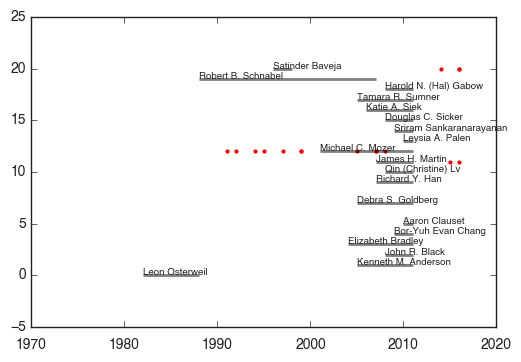

In [7]:
for i, person in enumerate(hires_and_publications):
    if not person["start"]:
        continue
    plt.plot([person["start"], person["end"]], [i, i], linewidth=2, color = 'k', alpha = .5)
    plt.text(person["start"], i, person["facultyName"], fontsize=7)
    
    if len(person['pubs']) > 0:
        plt.scatter(person['pubs'], [i]*len(person['pubs']), s = 4, color = 'r')

plt.xlim(1970, 2020)
plt.show()

Did the first deep-learning publication coincide with a faculty hiring event? Is the date of publication within two years of the author's hire? 

**Note:** Should we consider:
(1) window around hire data - the person the made the first deep learning contribution
(2) window around first relevant pub data

Keep in mind: do we often see a big gap in deep learning pubs between pre- and post-hire?

In [8]:
first_date = 2020;
for i, person in enumerate(hires_and_publications):
    if not person["start"] and len(person['pubs']) == 0:
        continue
        
    for pub in person["pubs"]:
        if pub >= person["start"] and pub < person["end"]:
            first_date = min(first_date, pub)
            
print "Date of university's first \"deep-learning\" publication: {0}".format(first_date)

Date of university's first "deep-learning" publication: 2005


Did the university hire someone who works on deep-learning within that date - 2 years (allowing for some start-up time)?

In [9]:
delta_t = 2; count_hiring_event = 0; count_nonhiring_event = 0;
for i, person in enumerate(hires_and_publications):
    if not person["start"] or len(person['pubs']) == 0:
        continue
        
    if person["start"] >= (first_date - delta_t) and person["start"] < first_date :
        print person["facultyName"]
        count_hiring_event += 1
    else:
        count_nonhiring_event += 1
            
print "\nNumber of \"deep-learning\" researchers who's hiring might have led to the research area: {0}".format(count_hiring_event)


Number of "deep-learning" researchers who's hiring might have led to the research area: 0


## For all universities

In [10]:
for place in inst.keys():
    if place == "UNKNOWN":
        continue
        
    hires_and_publications = []
    for f in faculty_at_institution(place):
        person = {"facultyName": f.facultyName}
    
        for job in f.faculty:
            if job['place'] == place:
                person["start"] = job['start_year']
                person["end"] = job['end_year']
    
        relevant_pubs = []
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any(pub['title'].lower().count(keyword) for keyword in deep_learning_keywords):
                    relevant_pubs.append(pub['year'])
        person["pubs"] = relevant_pubs
    
        hires_and_publications.append(person)
    
    first_date = 2020;
    for i, person in enumerate(hires_and_publications):
        if not person["start"] and len(person['pubs']) == 0:
            continue
        
        for pub in person["pubs"]:
            if pub >= person["start"] and pub < person["end"]:
                first_date = min(first_date, pub)
                
    if first_date == 2020:
        print "No \"deep-learning\" publications found for {0}!\n".format(place)
    else:
        print "Date of {0}'s first \"deep-learning\" publication: {1}".format(place, first_date)
    
        delta_t = 2; count_hiring_event = 0; count_nonhiring_event = 0;
        for i, person in enumerate(hires_and_publications):
            if not person["start"] or len(person['pubs']) == 0:
                continue
        
            if person["start"] >= (first_date - delta_t) and person["start"] < first_date :
                count_hiring_event += 1
            else:
                count_nonhiring_event += 1
            
        print "Number of \"deep-learning\" researchers who's hiring might have led to the research area: {0}\n".format(count_hiring_event)

Date of Syracuse University's first "deep-learning" publication: 1999
Number of "deep-learning" researchers who's hiring might have led to the research area: 0

Date of Brown University's first "deep-learning" publication: 1989
Number of "deep-learning" researchers who's hiring might have led to the research area: 1

Date of Michigan Technological University's first "deep-learning" publication: 2009
Number of "deep-learning" researchers who's hiring might have led to the research area: 0

No "deep-learning" publications found for Rice University!

Date of University of Connecticut's first "deep-learning" publication: 2008
Number of "deep-learning" researchers who's hiring might have led to the research area: 0

No "deep-learning" publications found for State University of New York, Albany!

Date of University of Florida's first "deep-learning" publication: 1987
Number of "deep-learning" researchers who's hiring might have led to the research area: 1

Date of UC Santa Barbara's first "d